In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Хакатоны/Yaro

In [ ]:
!pip install catboost
!pip install optuna

In [9]:
import pandas as pd 
from pandas.tseries.offsets import DateOffset
pd.options.display.max_columns = 200

import numpy as np
import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc , accuracy_score, f1_score, recall_score, precision_score


from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

# Анализ и предобработка данных

Для начала посмотрим на тренировочные данные:

In [10]:
# читаем датасет
train = pd.read_csv("train.csv")
train = train.drop(['ID', 'ID_y'], axis=1)

print(train.shape)
train.head(2)

(955, 37)


,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,15.0,20.0,0,NaN,употребляю в настоящее время,18.0,22:00:00,06:00:00,0,0,0,0,0,0,0,0
1,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,00:00:00,04:00:00,1,0,0,1,1,0,0,0


Оценим наличие корреляции в зависимых переменных:

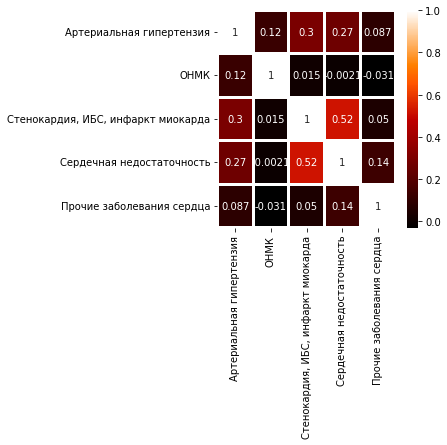

In [11]:
plt.figure(figsize=(4,4)) 
sns.heatmap(train[['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 
                  'Сердечная недостаточность', 'Прочие заболевания сердца',]].corr(), annot=True, cmap='gist_heat', linewidths = 2)
plt.show()

Введем 2 новых бинарных переменных: 
- засыпает ли человек после 22:00 или нет
- просыпается ли человек после 9:00 или нет

In [12]:
train['Засыпает после 22'] = np.where((train['Время засыпания'].isin(['22:00:00', '21:00:00','21:30:00', '20:30:00', '20:00:00'])), 0, train['Время засыпания'])
train['Засыпает после 22'] = np.where((train['Засыпает после 22'] != 0), 1, train['Засыпает после 22'])

train['Встает после 9'] = np.where((train['Время пробуждения'].isin(['10:00:00', '09:30:00', '12:00:00', '11:00:00','10:30:00', '09:00:00'])), 1, train['Время пробуждения'])
train['Встает после 9'] = np.where((train['Встает после 9'] != 1), 0, train['Встает после 9'])

In [13]:
train['Засыпает после 22'].value_counts()

1    737
0    218
Name: Засыпает после 22, dtype: int64

In [14]:
train['Встает после 9'].value_counts()

0    849
1    106
Name: Встает после 9, dtype: int64

Далее введем переменную продолжительности сна:

In [ ]:
train['Время засыпания'] = train['Время засыпания'].astype('datetime64[ns]')
train['Время засыпания'].loc[train['Время засыпания'].dt.hour.isin([20, 21, 22, 23])] = train['Время засыпания'].dt.to_period('ns').dt.to_timestamp() - DateOffset(days=1)

train['Время пробуждения'] = train['Время пробуждения'].astype('datetime64[ns]')
train['Время сна'] = (train['Время пробуждения'] - train['Время засыпания']).astype('timedelta64[h]')

#там где ошибочно стоит отрицательное время сна заменим на самое частотное(7 часов)
train['Время сна'] = np.where((train['Время сна'] <= 0.0), 7.0, train['Время сна'])

Сделаем переменную "Национальность" бинарной:

In [16]:
train['Национальность'] = np.where((train['Национальность'] != 'Русские'), 'Другое', train['Национальность'])

Еще 2 небольших изменения:
- удалим уже ненужные переменные 'Время засыпания' и 'Время пробуждения'
- удалим строку с пропуском в графе 'Пол'

In [17]:
train = train.drop(['Время засыпания', 'Время пробуждения'], axis=1)
train = train[train['Пол'].notna()]

Все пропуски заменим на 0, так как везде по смыслу так и должно быть: 

In [18]:
train.fillna(0, inplace=True)

Теперь посмотрим на тестовый датасет и повторим все операции, которые применяли для тренировочного:

In [19]:
# читаем датасет
test = pd.read_csv("test.csv")
test = test.drop(['ID'], axis=1)

print(test.shape)
test.head(2)

(638, 32)


,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
0,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,1,1,1,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,23.0,21:30:00,05:00:00,0,1,1
1,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,22.0,00:00:00,09:00:00,0,0,0


In [20]:
test['Засыпает после 22'] = np.where((test['Время засыпания'].isin(['22:00:00', '21:00:00', '21:50:00''21:30:00', '20:30:00', '20:00:00'])), 0, test['Время засыпания'])
test['Засыпает после 22'] = np.where((test['Засыпает после 22'] != 0), 1, test['Засыпает после 22'])


test['Встает после 9'] = np.where((test['Время пробуждения'].isin(['10:00:00', '09:30:00', '12:00:00', '11:00:00','10:30:00', '09:00:00'])), 1, test['Время пробуждения'])
test['Встает после 9'] = np.where((test['Встает после 9'] != 1), 0, test['Встает после 9'])

In [ ]:
test['Время засыпания'] = test['Время засыпания'].astype('datetime64[ns]')
test['Время засыпания'].loc[test['Время засыпания'].dt.hour.isin([20, 21, 22, 23])] = test['Время засыпания'].dt.to_period('ns').dt.to_timestamp() - DateOffset(days=1)

test['Время пробуждения'] = test['Время пробуждения'].astype('datetime64[ns]')
test['Время сна'] = (test['Время пробуждения'] - test['Время засыпания']).astype('timedelta64[h]')

#там где ошибочно стоит отрицательное время сна заменим на самое частотное(8 часов)
test['Время сна'] = np.where((test['Время сна'] <= 0.0), 8.0, test['Время сна'])

In [22]:
test = test.drop(['Время засыпания', 'Время пробуждения'], axis=1)
test['Национальность'] = np.where((test['Национальность'] != 'Русские'), 'Другое', test['Национальность'])
test.fillna(0, inplace=True)

Объединим тренировочную и тестовую выборки:

In [23]:
df = train.append(test)
df.reset_index(drop=True, inplace=True)

Закодируем категориальные переменные с помощью one-hot encoding:

In [24]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
df = pd.get_dummies(df, columns=categorical_columns)
df.tail(2)

,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Возраст курения,Сигарет в день,Пассивное курение,Возраст алког,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца,Засыпает после 22,Встает после 9,Время сна,Пол_Ж,Пол_М,Семья_в браке в настоящее время,Семья_в разводе,Семья_вдовец / вдова,Семья_гражданский брак / проживание с партнером,Семья_никогда не был(а) в браке,Семья_раздельное проживание (официально не разведены),"Этнос_другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан)",Этнос_европейская,"Этнос_прочее (любая иная этно-расовая группа, не представленная выше)",Национальность_Другое,Национальность_Русские,Религия_Атеист / агностик,Религия_Другое,Религия_Индуизм,Религия_Ислам,Религия_Нет,Религия_Христианство,Образование_2 - начальная школа,Образование_3 - средняя школа / закон.среднее / выше среднего,Образование_4 - профессиональное училище,Образование_5 - ВУЗ,Профессия_ведение домашнего хозяйства,Профессия_вооруженные силы,Профессия_дипломированные специалисты,Профессия_квалифицированные работники сельского хозяйства и рыболовного,Профессия_низкоквалифицированные работники,Профессия_операторы и монтажники установок и машинного оборудования,"Профессия_представители законодат. органов власти, высокопостав. долж.лица и менеджеры","Профессия_работники, занятые в сфере обслуживания, торговые работники магазинов и рынков",Профессия_ремесленники и представители других отраслей промышленности,Профессия_служащие,Профессия_техники и младшие специалисты,Статус Курения_Бросил(а),Статус Курения_Курит,Статус Курения_Никогда не курил,Статус Курения_Никогда не курил(а),Частота пасс кур_0,Частота пасс кур_1-2 раза в неделю,Частота пасс кур_2-3 раза в день,Частота пасс кур_3-6 раз в неделю,Частота пасс кур_4 и более раз в день,Частота пасс кур_не менее 1 раза в день,Алкоголь_никогда не употреблял,Алкоголь_ранее употреблял,Алкоголь_употребляю в настоящее время
1590,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,8.0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1591,1,0,0,0,1,0,1,0,0,0,1,0,1,0.0,0.0,0,17.0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,5.0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1


Разделим данные обратно на тренировочное и тестовое множества:

In [25]:
train = df[:954]
test = df[954:]

#удаляем ID и TАRGET из тренировочной выборки:
test = test.drop(['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 
                  'Сердечная недостаточность', 'Прочие заболевания сердца',], axis=1)

train.shape, test.shape

((954, 75), (638, 70))

Разделим переменные в тренировочном множестве:

In [26]:
#в качестве зависимой переменной берем TARGET:
y_1 = train['Артериальная гипертензия']
y_2 = train['ОНМК']
y_3 = train['Стенокардия, ИБС, инфаркт миокарда']
y_4 = train['Сердечная недостаточность']
y_5 = train['Прочие заболевания сердца']

#удаляем ID и TАRGET из тренировочной выборки:
x_train = train.drop(['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 
                    'Сердечная недостаточность', 'Прочие заболевания сердца'], axis=1)

x_test = test
x_train.shape

(954, 70)

# Обучение алгоритмов и предсказания для теста

В качестве основного алгоритма для решения задачи будет использоваться бустинг. А именно 5 независимых, разных CatBoost для каждой прогнозируемой переменной.

Для первых 4 бустингов будем подбирать оптимальные гиперпараметры с помощью библиотеки optuna. Особое внимание нужно уделить параметру scale_pos_weight, так как в 4 из 5 прогнозируемых переменных значения несбалансированны.

Функция для подбора основных гиперпараметров, которая стремится максимизировать recall_macro:

In [27]:
def objective(trial, X=x_train, y=y_1):

  recall_list = []  

  kf = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
  X = X.reset_index(drop=True)
  y = y.reset_index(drop=True)

  param = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.004, 0.02),
        'n_estimators':  trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 3.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'random_state': trial.suggest_categorical('random_state', [42]),
    }


  cb = CatBoostClassifier(verbose=False, **param)
  for i, (train_index, test_index) in enumerate(kf.split(X, y)):
          
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cb.fit(X_train, y_train)
    predict = cb.predict(X_test)

    recall = recall_score(y_test, predict, average='macro')
    recall_list.append(recall)
            
  return float(round(np.mean(recall_list), 4))

Подбираем параметры:

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)
print(study.best_trial)
print('Best trial:', study.best_trial.params)

Визуализация подбора параметров:

In [29]:
optuna.visualization.plot_parallel_coordinate(study)

Сохраняем их в переменную:

In [30]:
best_param_1 = {'learning_rate': 0.016202975941181315, 'n_estimators': 77, 'max_depth': 7, 'scale_pos_weight': 1.16267275066011, 'min_data_in_leaf': 7, 'l2_leaf_reg': 0.11627862676056576, 'max_bin': 333, 'subsample': 0.4189444667844855, 'random_state': 42}

Функция для стратифицированной kfold кроссвалидации:

In [31]:
def kfold(X, y, model, splits):

  accuracy_list = []
  precision_list = []
  recall_list = []  
  f1_list = []

  kf = StratifiedKFold(n_splits = splits, random_state = 42, shuffle = True)
  X = X.reset_index(drop=True)
  y = y.reset_index(drop=True)
      
  for i, (train_index, test_index) in enumerate(kf.split(X, y)):
          
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)

    acc = accuracy_score(y_test, predict)
    precision = precision_score(y_test, predict, zero_division=0)
    recall = recall_score(y_test, predict, average='macro')
    f1 = f1_score(y_test, predict)

    # print('fold:', i, 'acc:', acc)
    # print('fold:', i, 'precision:', precision)
    print(i, round(recall,4))
    # print('fold:', i, 'f1:', f1)

    accuracy_list.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
            
  print('accuracy:', round(np.mean(accuracy_list),4))
  print('--------------')
  print('precision:', round(np.mean(precision_list),4))
  print('--------------')
  print('recall-macro:', round(np.mean(recall_list),4))
  print('--------------')
  print('f1_score:', round(np.mean(f1_list),4))

Проверяем еще раз качество модели с помощью найденных параметров:

In [32]:
cb_1 = CatBoostClassifier(verbose=False, **best_param_1)

kfold(x_train, y_1, cb_1, 3)

0 0.7441
1 0.7453
2 0.7145
accuracy: 0.7285
--------------
precision: 0.6695
--------------
recall-macro: 0.7346
--------------
f1_score: 0.7408


Обучаем алгоритм для всех тренировочных данный и делаем прогноз для тестовых:

In [33]:
#обучаем модель на всех данных
cb_1.fit(x_train, y_1)

#записываем прогноз
pred_1 = cb_1.predict(x_test)

print(len(pred_1))
np.unique(pred_1, return_counts=True)

638


(array([0., 1.]), array([287, 351]))

Посмотрим на значимость переменных при построении алгоритма:

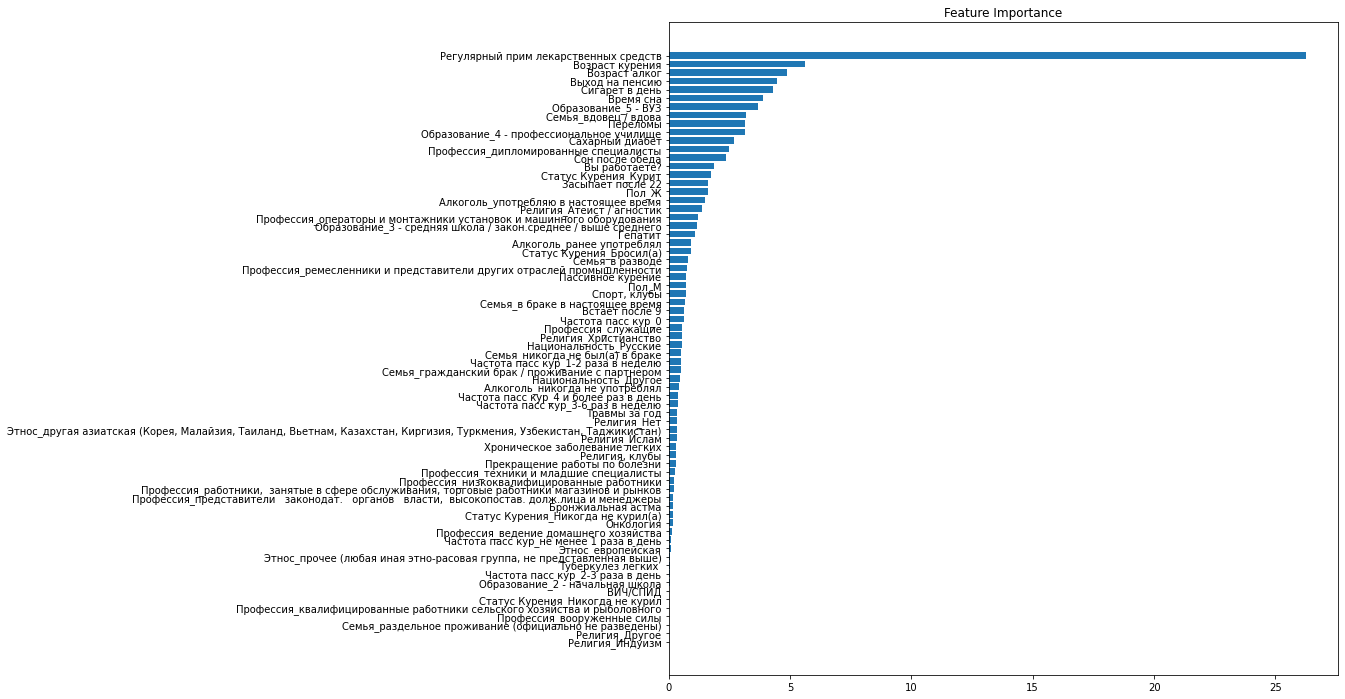

In [34]:
feature_importance = cb_1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

Аналогично повторяем процедуру поиска гиперпараметров, обучения на всех данных и построения прогнозов с помощью других бустингов для следующих 3 переменных:

In [ ]:
def objective(trial, X=x_train, y=y_2):

  recall_list = []  

  kf = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
  X = X.reset_index(drop=True)
  y = y.reset_index(drop=True)

  param = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.004, 0.02),
        'n_estimators':  trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 25.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'random_state': trial.suggest_categorical('random_state', [42]),
    }


  cb = CatBoostClassifier(verbose=False, **param)
  for i, (train_index, test_index) in enumerate(kf.split(X, y)):
          
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cb.fit(X_train, y_train)
    predict = cb.predict(X_test)

    recall = recall_score(y_test, predict, average='macro')
    recall_list.append(recall)
            
  return float(round(np.mean(recall_list), 4))

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)
print(study.best_trial)
print('Best trial:', study.best_trial.params)

In [ ]:
best_param_2 = {'learning_rate': 0.017472316351031955, 'n_estimators': 98, 'max_depth': 2, 'scale_pos_weight': 24.983258371687516, 'min_data_in_leaf': 218, 'l2_leaf_reg': 7.9761118886962175, 'max_bin': 323, 'subsample': 0.23879145814403058, 'random_state': 42}

In [ ]:
cb_2 = CatBoostClassifier(verbose=False, **best_param_2)

kfold(x_train, y_2, cb_2, 3)

0 0.6175
1 0.6602
2 0.6696
accuracy: 0.6415
--------------
precision: 0.0764
--------------
recall-macro: 0.6491
--------------
f1_score: 0.1368


In [ ]:
#обучаем модель на всех данных
cb_2.fit(x_train, y_2)

#записываем прогноз
pred_2 = cb_2.predict(x_test)

print(len(pred_2))
np.unique(pred_2, return_counts=True)

638


(array([0., 1.]), array([377, 261]))

In [ ]:
def objective(trial, X=x_train, y=y_3):

  recall_list = []  

  kf = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
  X = X.reset_index(drop=True)
  y = y.reset_index(drop=True)

  param = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.004, 0.02),
        'n_estimators':  trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'random_state': trial.suggest_categorical('random_state', [42]),
    }


  cb = CatBoostClassifier(verbose=False, **param)
  for i, (train_index, test_index) in enumerate(kf.split(X, y)):
          
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cb.fit(X_train, y_train)
    predict = cb.predict(X_test)

    recall = recall_score(y_test, predict, average='macro')
    recall_list.append(recall)
            
  return float(round(np.mean(recall_list), 4))

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)
print(study.best_trial)
print('Best trial:', study.best_trial.params)

In [ ]:
best_param_3 = {'learning_rate': 0.0096683232466077, 'n_estimators': 217, 'max_depth': 2, 'scale_pos_weight': 7.102096433896974, 'min_data_in_leaf': 85, 'l2_leaf_reg': 5.853117668916306, 'max_bin': 386, 'subsample': 0.21663660636404822, 'random_state': 42}

In [ ]:
cb_3 = CatBoostClassifier(verbose=False, **best_param_3)

kfold(x_train, y_3, cb_3, 3)

0 0.7102
1 0.7266
2 0.6923
accuracy: 0.6971
--------------
precision: 0.2491
--------------
recall-macro: 0.7097
--------------
f1_score: 0.3709


In [ ]:
#обучаем модель на всех данных
cb_3.fit(x_train, y_3)

#записываем прогноз
pred_3 = cb_3.predict(x_test)

print(len(pred_3))
np.unique(pred_3, return_counts=True)

638


(array([0., 1.]), array([435, 203]))

In [ ]:
def objective(trial, X=x_train, y=y_4):

  recall_list = []  

  kf = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
  X = X.reset_index(drop=True)
  y = y.reset_index(drop=True)

  param = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.004, 0.02),
        'n_estimators':  trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 15.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'random_state': trial.suggest_categorical('random_state', [42]),
    }


  cb = CatBoostClassifier(verbose=False, **param)
  for i, (train_index, test_index) in enumerate(kf.split(X, y)):
          
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cb.fit(X_train, y_train)
    predict = cb.predict(X_test)

    recall = recall_score(y_test, predict, average='macro')
    recall_list.append(recall)
            
  return float(round(np.mean(recall_list), 4))

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)
print(study.best_trial)
print('Best trial:', study.best_trial.params)

In [ ]:
best_param_4 = {'learning_rate': 0.009059934523996924, 'n_estimators': 164, 'max_depth': 8, 'scale_pos_weight': 13.962506892014368, 'min_data_in_leaf': 218, 'l2_leaf_reg': 8.78223522800209, 'max_bin': 267, 'subsample': 0.6665198690768868, 'random_state': 42}

In [ ]:
cb_4 = CatBoostClassifier(verbose=False, **best_param_4)

kfold(x_train, y_4, cb_4, 3)

0 0.7297
1 0.6637
2 0.7473
accuracy: 0.6761
--------------
precision: 0.2048
--------------
recall-macro: 0.7135
--------------
f1_score: 0.3223


In [ ]:
#обучаем модель на всех данных
cb_4.fit(x_train, y_4)

#записываем прогноз
pred_4 = cb_4.predict(x_test)

print(len(pred_4))
np.unique(pred_4, return_counts=True)

638


(array([0., 1.]), array([381, 257]))

Для переменной "Прочие заболевания сердца" подберем параметры эмпирически, так как из-за сильной несбалансированности трудно соблюдать баланс между accuracy и roc_auc_macro:

In [ ]:
cb_5 = CatBoostClassifier(random_state = 42, learning_rate = 0.01, max_depth=4,
                        n_estimators = 100, verbose=False,
                        class_weights=[1, 12])

kfold(x_train, y_5, cb_5, 3)

0 0.5398
1 0.5663
2 0.594
accuracy: 0.4979
--------------
precision: 0.1113
--------------
recall-macro: 0.5667
--------------
f1_score: 0.1899


In [ ]:
#обучаем модель на всех данных
cb_5.fit(x_train, y_5)

#записываем прогноз
pred_5 = cb_5.predict(x_test)

print(len(pred_5))
np.unique(pred_5, return_counts=True)

638


(array([0., 1.]), array([300, 338]))

# Оформление итогового прогноза

In [ ]:
sample = pd.read_csv("sample_solution.csv")
sample.head(2)

,ID,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-001-019-01,0,0,0,0,0
1,54-002-133-01,0,0,0,0,0


In [ ]:
sample['Артериальная гипертензия'] = pred_1
sample['ОНМК'] = pred_2
sample['Стенокардия, ИБС, инфаркт миокарда'] = pred_3
sample['Сердечная недостаточность'] = pred_4
sample['Прочие заболевания сердца'] = pred_5

sample = sample.astype({'Артериальная гипертензия': int, 'ОНМК': int, 'Стенокардия, ИБС, инфаркт миокарда': int,
                        'Сердечная недостаточность': int, 'Прочие заболевания сердца': int})

sample.dtypes

ID                                    object
Артериальная гипертензия               int64
ОНМК                                   int64
Стенокардия, ИБС, инфаркт миокарда     int64
Сердечная недостаточность              int64
Прочие заболевания сердца              int64
dtype: object

Посмотрим на прогнозируемые значения для каждой переменной:

In [ ]:
sample['Артериальная гипертензия'].value_counts()

1    351
0    287
Name: Артериальная гипертензия, dtype: int64

In [ ]:
sample['ОНМК'].value_counts()

0    377
1    261
Name: ОНМК, dtype: int64

In [ ]:
sample['Стенокардия, ИБС, инфаркт миокарда'].value_counts()

0    435
1    203
Name: Стенокардия, ИБС, инфаркт миокарда, dtype: int64

In [ ]:
sample['Сердечная недостаточность'].value_counts()

0    381
1    257
Name: Сердечная недостаточность, dtype: int64

In [ ]:
sample['Прочие заболевания сердца'].value_counts()

1    338
0    300
Name: Прочие заболевания сердца, dtype: int64

Сохраним финальный результат:

In [ ]:
sample.to_csv("submit_final.csv", index=False)